# 1. Introdution

* Дан датасет с параметрами домов House Prices
* Задача провести анализ и построить модель, которая предсказывает цену дома
# 2. Import Librares

In [1]:
# Загружаем библиотеки
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Модели 
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
import lightgbm as lgb

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, mean_squared_error, make_scorer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import re, warnings
warnings.filterwarnings("ignore")

# 3. Load Data

In [2]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# 4. EDA & Data Preprocessing

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Fill Nan

In [4]:
missing = train.isnull().sum()
missing[missing > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Избавляемся от пропусков:
* LotFrontage      259 - Это линейная часть улицы прилегающая к территории, думаю можно заменить на медиану
* Alley           1369 - NA это No alley access, можно заменить на 0
* MasVnrType       872 - Тип каменной укладки, заменяем на 0
* MasVnrArea         8 - площадь укладки, заменяем на медиану по группировке с MasVnrType
* BsmtQual          37 - NA No Basement, заменяем на 0
* BsmtCond          37 - NA No Basement, заменяем на 0
* BsmtExposure      38 - NA No Basement, заменяем на 0
* BsmtFinType1      37 - NA No Basement, заменяем на 0
* BsmtFinType2      38 - NA No Basement, заменяем на 0
* Electrical         1 - Электричества, ставим моду
* FireplaceQu      690 - NA No Fireplace, ставим 0
* GarageType        81 - NA No Garage, ставим 0
* GarageYrBlt       81 - NA No Garage, ставим 0
* GarageFinish      81 - NA No Garage, ставим 0
* GarageQual        81 - NA No Garage, ставим 0
* GarageCond        81 - NA No Garage, ставим 0
* PoolQC          1453 - NA No Pool, ставим 0
* Fence           1179 - NA No Fence, ставим 0
* MiscFeature     1406 - NA None, ставим 0

In [5]:
# Копируем датасет, чтобы не портить оригинал
df = train.copy()

# 1. LotFrontage — медиана (по району можно, но пока общий вариант)
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

# 2. Alley — NA = No alley access
df["Alley"] = df["Alley"].fillna("None")

# 3. MasVnrType / MasVnrArea
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(df["MasVnrArea"].median())

# 4. Basement
for col in ["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"]:
    df[col] = df[col].fillna("None")

# 5. Electrical — мода
df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

# 6. Fireplace
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")

# 7. Garage
for col in ["GarageType","GarageFinish","GarageQual","GarageCond"]:
    df[col] = df[col].fillna("None")
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(0)

# 8. Pool / Fence / MiscFeature
df["PoolQC"] = df["PoolQC"].fillna("None")
df["Fence"] = df["Fence"].fillna("None")
df["MiscFeature"] = df["MiscFeature"].fillna("None")


In [6]:
# Копируем тест, чтобы не портить оригинал
test_df = test.copy()

# 1. LotFrontage — медиана по району
test_df["LotFrontage"] = test_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

# 2. Alley — NA = No alley access
test_df["Alley"] = test_df["Alley"].fillna("None")

# 3. MasVnrType / MasVnrArea
test_df["MasVnrType"] = test_df["MasVnrType"].fillna("None")
test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna(test_df["MasVnrArea"].median())

# 4. Basement
for col in ["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"]:
    test_df[col] = test_df[col].fillna("None")

# 5. Electrical — мода
test_df["Electrical"] = test_df["Electrical"].fillna(test_df["Electrical"].mode()[0])

# 6. Fireplace
test_df["FireplaceQu"] = test_df["FireplaceQu"].fillna("None")

# 7. Garage
for col in ["GarageType","GarageFinish","GarageQual","GarageCond"]:
    test_df[col] = test_df[col].fillna("None")
test_df["GarageYrBlt"] = test_df["GarageYrBlt"].fillna(0)

# 8. Pool / Fence / MiscFeature
test_df["PoolQC"] = test_df["PoolQC"].fillna("None")
test_df["Fence"] = test_df["Fence"].fillna("None")
test_df["MiscFeature"] = test_df["MiscFeature"].fillna("None")

## Analyz features
Посмотрим количество уникальных значений в категориальных признаках

In [7]:
cat_cols = df.columns[df.dtypes == "object"]

In [8]:
df[cat_cols].nunique()

MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64

Довольно много, из описания видим что в ExterQual, ExterCond, BsmtQual, HeatingQC (шкала качества: Ex=Excellent, Gd=Good, TA=Typical, Fa=Fair, Po=Poor). Переводим в цифры

In [9]:
qual_map = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0}
df["ExterQual"] = df["ExterQual"].map(qual_map)
df["ExterCond"] = df["ExterCond"].map(qual_map)
df["BsmtQual"] = df["BsmtQual"].map(qual_map)
df["HeatingQC"] = df["HeatingQC"].map(qual_map)

In [10]:
df[["ExterQual", "ExterCond", "BsmtQual", "HeatingQC"]].head()

,ExterQual,ExterCond,BsmtQual,HeatingQC
0,4,3,4,5
1,3,3,4,5
2,4,3,4,5
3,3,3,3,4
4,4,3,4,5


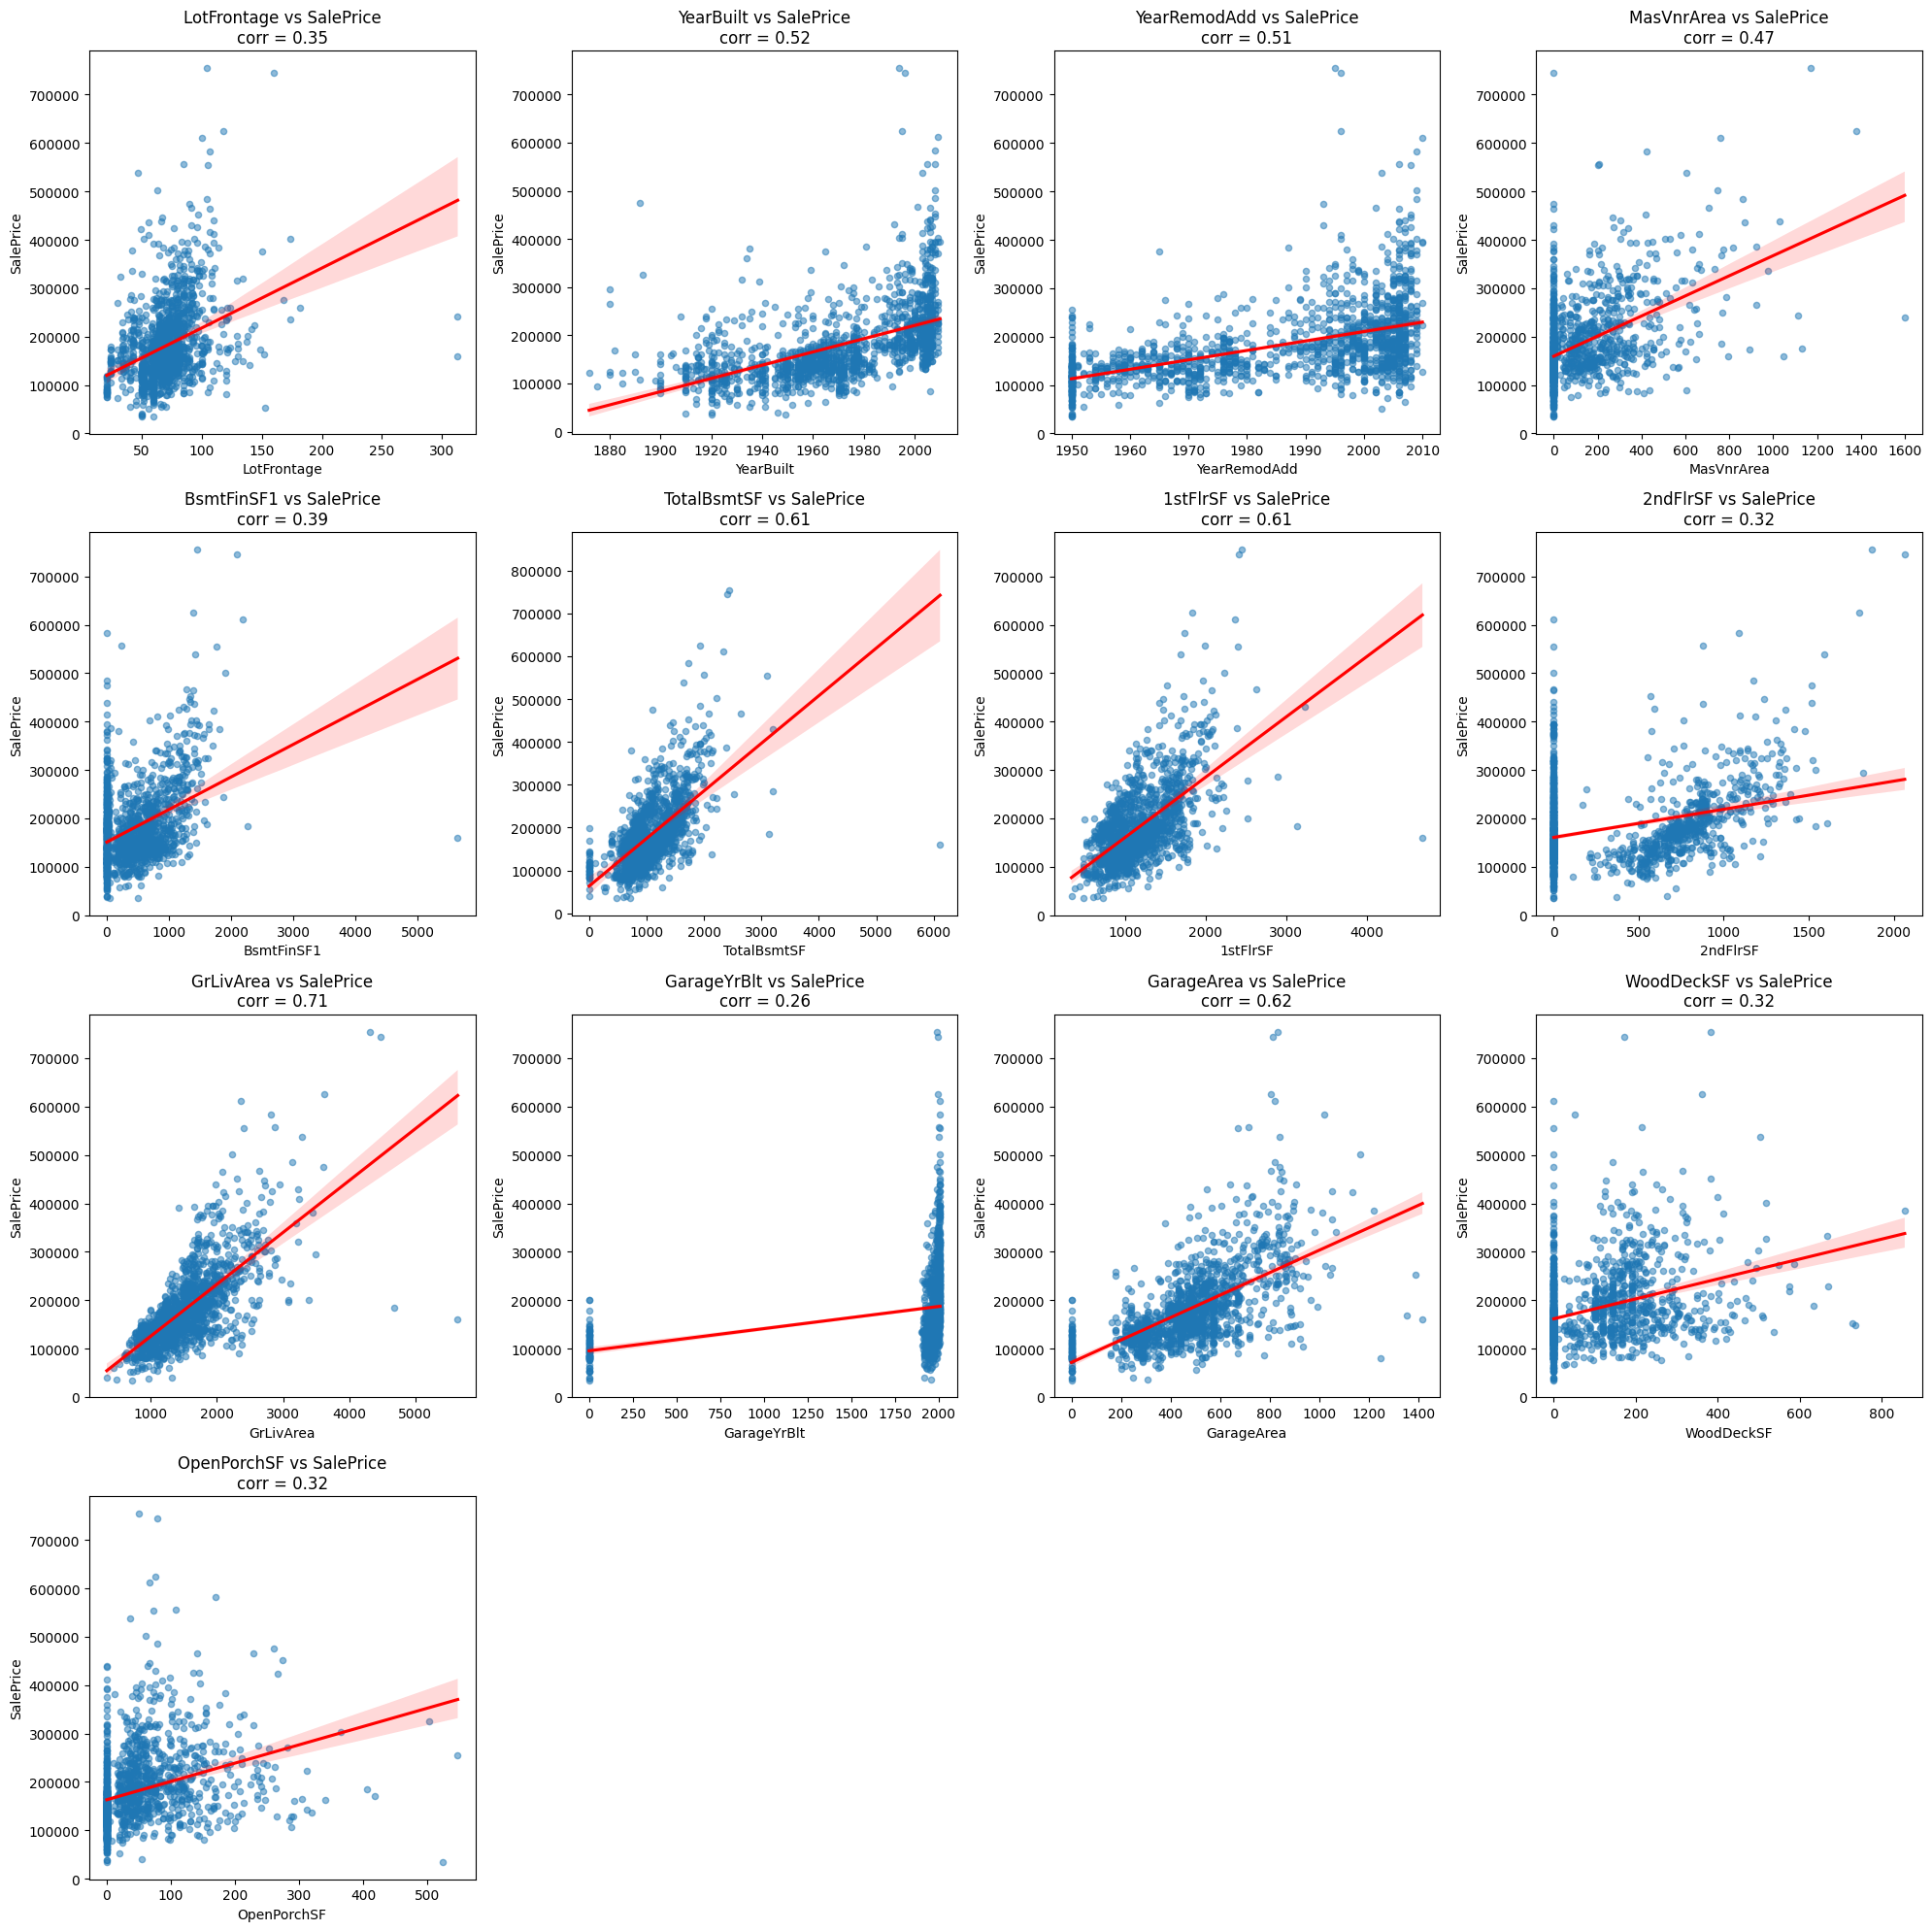

In [11]:
# Список числовых признаков, которые хотим сравнить с ценой
features = [
    "LotFrontage", "YearBuilt", "YearRemodAdd", "MasVnrArea",
    "BsmtFinSF1", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
    "GrLivArea", "GarageYrBlt", "GarageArea",
    "WoodDeckSF", "OpenPorchSF"
]

n_cols = 4
n_rows = int(np.ceil(len(features) / n_cols))

plt.figure(figsize=(20, 20))

for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # считаем корреляцию
    corr = df[[col, "SalePrice"]].corr().iloc[0,1]
    
    sns.regplot(
        data=df, x=col, y="SalePrice",
        scatter_kws={"alpha": 0.5, "s": 20},
        line_kws={"color": "red"}
    )
    
    plt.title(f"{col} vs SalePrice\ncorr = {corr:.2f}")

plt.tight_layout()
plt.show()

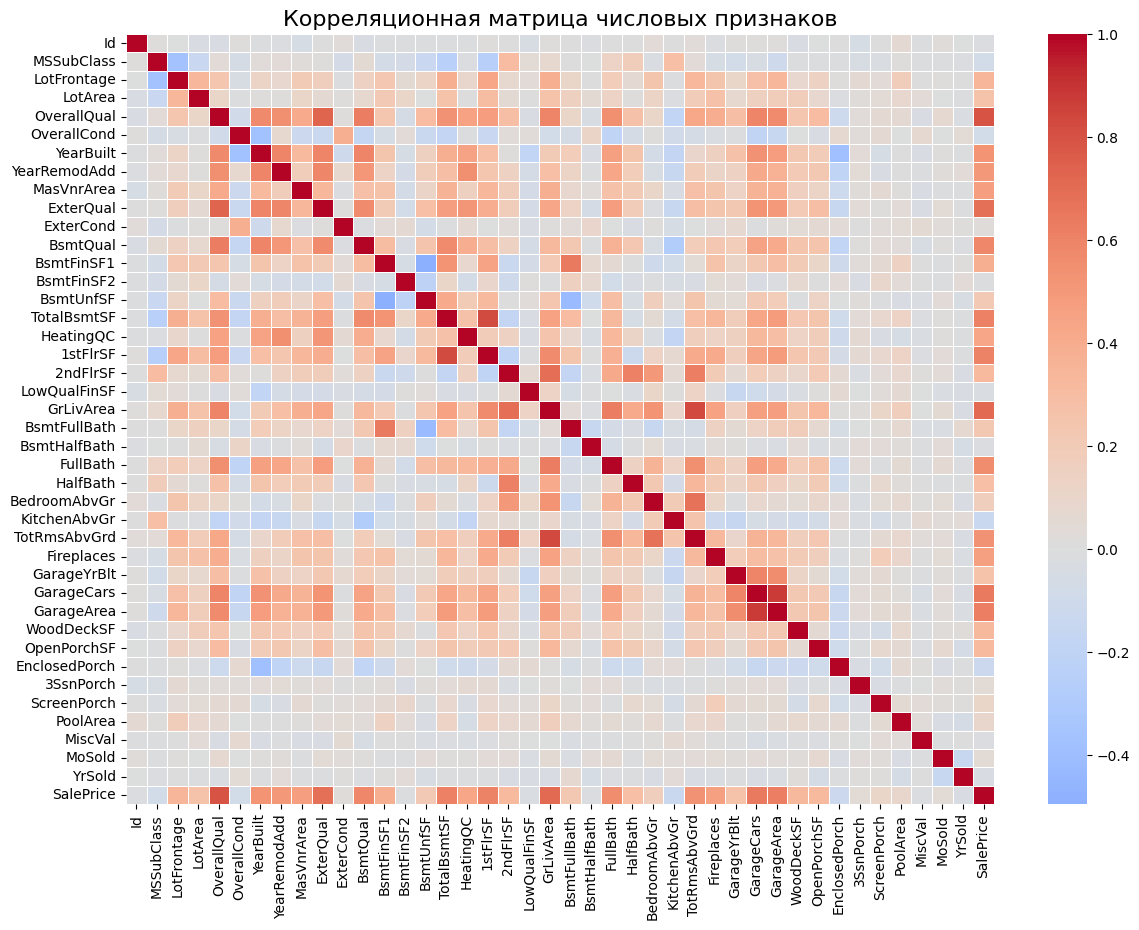

In [12]:
# Берём только числовые признаки
numeric_df = df.select_dtypes(include=[np.number])

# Корреляционная матрица
corr_matrix = numeric_df.corr()

plt.figure(figsize=(14,10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Корреляционная матрица числовых признаков", fontsize=16)
plt.show()

Слишком много признаков, получилась куча-мала, попробуем отобрать только самые значимые 15

In [13]:
corr_with_target = corr_matrix["SalePrice"].sort_values(ascending=False)
print(corr_with_target.head(15))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
Name: SalePrice, dtype: float64


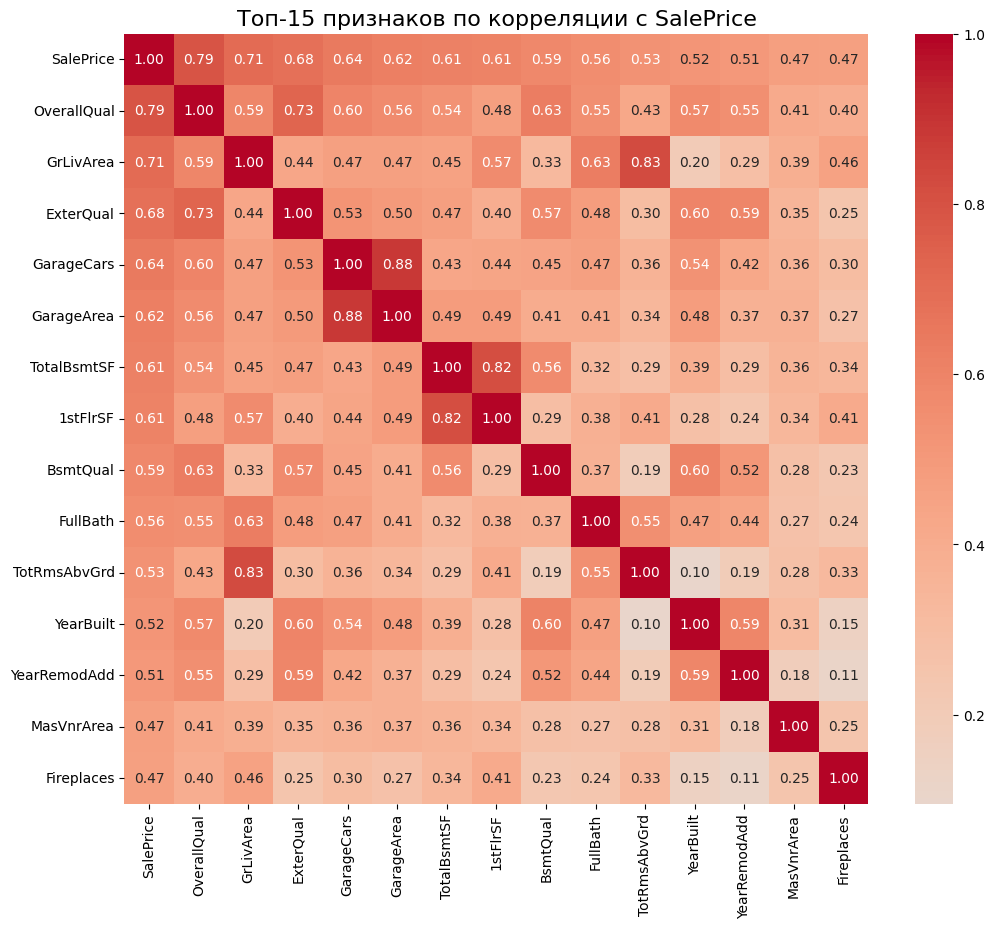

In [14]:
# 1. Берём только числовые признаки
numeric_df = df.select_dtypes(include=[np.number])

# 2. Считаем корреляции
corr_matrix = numeric_df.corr()

# 3. Берём топ-15 по связи с ценой
top_features = corr_matrix["SalePrice"].abs().sort_values(ascending=False).head(15).index

# 4. Строим heatmap только для этих признаков
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix.loc[top_features, top_features],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Топ-15 признаков по корреляции с SalePrice", fontsize=16)
plt.show()

Ну в целом видно признаки коррелирующие с ценой.

## Feature Engineering

добавим несколько признаков, которые могут быть полезны

In [15]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # 1. Общая площадь (важнейший признак)
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

    # 2. Возраст дома и возраст после ремонта
    df["Age"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]

    # 3. Площадь над землёй + подвал
    df["TotalArea"] = df["GrLivArea"] + df["TotalBsmtSF"]

    # 4. Общее количество ванных
    df["TotalBath"] = (
        df["FullBath"] + 0.5 * df["HalfBath"] +
        df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"]
    )

    # 5. Количество комнат (вариант)
    df["TotalRooms"] = df["TotRmsAbvGrd"] + df["BedroomAbvGr"] + df["KitchenAbvGr"]

    # 6. Индикаторы наличия объектов
    df["HasPool"] = (df["PoolArea"] > 0).astype(int)
    df["HasGarage"] = (df["GarageArea"] > 0).astype(int)
    df["HasFireplace"] = (df["Fireplaces"] > 0).astype(int)
    df["HasBsmt"] = (df["TotalBsmtSF"] > 0).astype(int)
    df["Has2ndFlr"] = (df["2ndFlrSF"] > 0).astype(int)

    # 7. Итоговый скор по качеству
    df["OverallScore"] = df["OverallQual"] * df["OverallCond"]
    
    return df

In [16]:
train_fe = feature_engineering(df)
test_fe  = feature_engineering(test_df)

In [17]:
train_fe.shape, test_fe.shape

((1460, 93), (1459, 92))

# 5. Model
Сделаем для начала модели с категориальными признаками

## Splitting

In [18]:
# Разделяем на признаки и целевую переменную
X = train_fe.drop("SalePrice", axis=1)
y = train_fe["SalePrice"]

# Train/test split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
X_train.shape

(1168, 92)

## OneHotEncoder

In [20]:
# Настройка OneHotEncoder
ohe_kwargs = dict(handle_unknown="ignore")
ver = tuple(map(int, sklearn.__version__.split(".")[:2]))
if ver >= (1, 2):
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

## RMSE scorer

In [21]:
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

## Numeric & Category

In [22]:
# разделим на отдельные датафреймя с признаками числовыми и катериальными
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(exclude=['int64','float64']).columns

## Pipelines

In [23]:
# Подготовим данные
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(**ohe_kwargs))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

#### Ridge + XGB

In [24]:
ridge_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge(alpha=10))
])

xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    ))
])

#### CatBoost

In [25]:
cat_features = cat_cols.tolist()

cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    loss_function="RMSE",
    random_state=42,
    verbose=0
)

#### Cross-validation

In [26]:
for name, model in [("Ridge", ridge_pipe), ("XGBoost", xgb_pipe)]:
    scores = cross_val_score(model, X, y, cv=5, scoring=rmse_scorer, n_jobs=-1)
    print(f"{name} RMSE (CV mean): {-scores.mean():.4f}")

Ridge RMSE (CV mean): 31050.5711
XGBoost RMSE (CV mean): 25942.8490


In [27]:
# CatBoost — вручную через cross_val_score не всегда дружит, делаем fit+predict в цикле
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cat_rmse = []
for train_idx, valid_idx in kf.split(X):
    X_tr, X_val = X.iloc[train_idx].copy(), X.iloc[valid_idx].copy()
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]
    # CatBoost требует object
    for col in cat_features:
        X_tr[col] = X_tr[col].astype(str)
        X_val[col] = X_val[col].astype(str)
    cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True, verbose=0)
    preds = cat_model.predict(X_val)
    cat_rmse.append(np.sqrt(mean_squared_error(y_val, preds)))

print(f"CatBoost RMSE (CV mean): {np.mean(cat_rmse):.4f}")

CatBoost RMSE (CV mean): 26031.1853


Имеем в итоге:
* Ridge RMSE (CV mean): 31050.5711
* XGBoost RMSE (CV mean): 25942.8490
* CatBoost RMSE (CV mean): 26031.1853

> XGBoost лучший результат

# 6. Submition

In [28]:
# 1. Подготовка train для XGBoost
df_xgb = X.copy()
cat_features = X.select_dtypes(include="object").columns.tolist()

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df_xgb[cat_features] = encoder.fit_transform(df_xgb[cat_features])

In [29]:
# 2. Обучение XGB на всём train
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)
xgb_model.fit(df_xgb, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [30]:
# Переводим в числовую шкалу в тестовой выборке
qual_map = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0}
mapped_cols = ["ExterQual", "ExterCond", "BsmtQual", "HeatingQC"]

for col in mapped_cols:
    test_fe[col] = test_fe[col].map(qual_map).fillna(0).astype(int)

In [31]:
test_fe[["ExterQual", "ExterCond", "BsmtQual", "HeatingQC"]]

,ExterQual,ExterCond,BsmtQual,HeatingQC
0,3,3,3,3
1,3,3,3,3
2,3,3,4,4
3,3,3,3,5
4,4,3,4,5
...,...,...,...,...
1454,3,3,3,4
1455,3,3,3,3
1456,3,3,3,5
1457,3,3,4,3


In [32]:
# 3. Подготовка test
test_xgb = test_fe.copy()
test_xgb[cat_features] = encoder.transform(test_xgb[cat_features])
test_xgb = test_xgb[df_xgb.columns]  # порядок как у train

In [33]:
# 4. Предсказание
pred_xgb = xgb_model.predict(test_xgb)

In [34]:
# 5. Submission
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": pred_xgb
})
submission.to_csv("submission.csv", index=False)

print("Файл submission.csv готов")

Файл submission.csv готов
